This notebook runs a Convolutional Neural Network and Random Forest to predict the binned yards gained. The CNN requires TensorFlow. This was originally made in Google Colab.

# Set up Environment

In [1]:
pip install keras-rectified-adam

  Created wheel for keras-rectified-adam: filename=keras_rectified_adam-0.17.0-cp36-none-any.whl size=14781 sha256=fde67c40747585e4969702e54d1e6d02c90bb64b7033011f6e73b276a9495681
  Stored in directory: /root/.cache/pip/wheels/7b/01/27/3a934e1a5644f5b93c720422a6ef97034ea78a21ba71cfb549
Successfully built keras-rectified-adam


In [17]:
import pickle
import pandas as pd
import numpy as np
# plots
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler # normalizing
import itertools
# Random Forest
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
# Convolutional Neural Network

#import keras
#from keras_radam import RAdam
#from keras.models import Sequential, Model
#from keras.layers import Input, Dense, Embedding, Concatenate, Flatten, BatchNormalization, Dropout
#from keras.callbacks import ModelCheckpoint
#from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
#from keras.utils.vis_utils import plot_model
#from keras import metrics
# Evaluation Metrics
from sklearn.metrics import confusion_matrix, classification_report, mean_squared_error
import warnings
warnings.filterwarnings("ignore")

In [18]:
 #to run this you need the data(2).pkl file in your Google Drive and to have your Google Drive mounted to the Colab Notebook
data = pd.read_pickle('data_more.pkl')

## Data Conversion
Most machine learning algorithms require numeric data
 - convert object and string variables to numeric
 - use dummy variables

### Game Clock to Seconds

In [0]:
## convert the game clock to seconds
def strtoseconds(txt):
    # get the different parts of the time
    txt = txt.split(':')
    # new time will be in seconds
    # minutes * 60 + seconds + microseconds/60
    new_time = int(txt[0])*60 + int(txt[1]) + int(txt[2])/60
    return new_time
# don't run this if you load data(1).pkl
data['gameclock'] = data['gameclock'].apply(strtoseconds)

### OL to int

In [0]:
# convert ol ot integer
data['ol'] = data['ol'].astype(int)

### Columns to Keep for Models
These include numeric columns and categorical columns to be converted with dummy variables

In [19]:
cols_to_keep = ['team',
 's',
 'a',
 'dis',
 'orientation',
 'dir',
 'season',
 'yardline',
 'quarter',
 'gameclock',
 'possessionteam',
 'down',
 'distance',
 'fieldposition',
 'homescorebeforeplay',
 'visitorscorebeforeplay',
 'offenseformation',
 'offensepersonnel',
 'defendersinthebox',
 'defensepersonnel',
 'yards', # this is the target variable - remove this for the test set
 'playerheight',
 'playerweight',
 'playercollegename',
 'position',
 'hometeamabbr',
 'visitorteamabbr',
 'week',
 'age',
 'time_since_snap',
 'rusher',
 'rushx',
 'rushy',
 'disttorush',
 'teamidentity',
 'min_distancetorusher',
 'ol_d',
 'dl',
 'lb',
 'db',
 'rb_d',
 'qb',
 'ol',
 'rb',
 'te',
 'wr',
 'dl_o',
 'lb_o',
 'db_o',
 'yardfromowngoal',
 'x_standard',
 'y_standard',
 'avgyardspergame',
 'x_handoff',
 'y_handoff',
 'offense',
 'eff_downfield_acc',
 'eff_crossfield_acc',
 'rushteamwinning',
 'playerblocked',
 'total_playersblocked_revised',
 'yards_binned',
 'rk_17',
 'g_17',
 'gs_17',
 'att_17',
 'yds_17',
 'td_17',
 '1d_17',
 'lng_17',
 'y/a_17',
 'y/g_17',
 'fmb_17',
 'rk_18',
 'g_18',
 'gs_18',
 'att_18',
 'yds_18',
 'td_18',
 '1d_18',
 'lng_18',
 'y/a_18',
 'y/g_18',
 'fmb_18',
 'rk_19',
 'g_19',
 'gs_19',
 'att_19',
 'yds_19',
 'td_19',
 '1d_19',
 'lng_19',
 'y/a_19',
 'y/g_19',
 'fmb_19',]

In [22]:
list(data.columns)

['gameid',
 'playid',
 'team',
 'x',
 'y',
 's',
 'a',
 'dis',
 'orientation',
 'dir',
 'nflid',
 'displayname',
 'jerseynumber',
 'season',
 'yardline',
 'quarter',
 'gameclock',
 'possessionteam',
 'down',
 'distance',
 'fieldposition',
 'homescorebeforeplay',
 'visitorscorebeforeplay',
 'nflidrusher',
 'offenseformation',
 'offensepersonnel',
 'defendersinthebox',
 'defensepersonnel',
 'playdirection',
 'timehandoff',
 'timesnap',
 'yards',
 'playerheight',
 'playerweight',
 'playerbirthdate',
 'playercollegename',
 'position',
 'hometeamabbr',
 'visitorteamabbr',
 'week',
 'stadium',
 'location',
 'stadiumtype',
 'turf',
 'gameweather',
 'temperature',
 'humidity',
 'windspeed',
 'winddirection',
 'age',
 'time_since_snap',
 'rusher',
 'rushx',
 'rushy',
 'disttorush',
 'teamidentity',
 'min_distancetorusher',
 'ol_d',
 'dl',
 'lb',
 'db',
 'rb_d',
 'qb',
 'ol',
 'rb',
 'te',
 'wr',
 'dl_o',
 'lb_o',
 'db_o',
 'yardfromowngoal',
 'x_standard',
 'y_standard',
 'runsuccess',
 'temp',

In [20]:
# label bins need to be in integers for neural network to get dummy variables for the label array
bin_int = {'-10 or less':0,
           '-9 to -4':1,
           '-3 to -1':2,
           '0 to 3':3,
           '4 to 7':4,
           '8 to 10':5,
           '11 to 15':6,
           '16 to 25':7,
           '26+':8}
data['yards_bin_int'] = data['yards_binned'].map(bin_int)
bin_yard_names = list(bin_int.keys())

(682154, 143)

### Distribution of Binned Yards

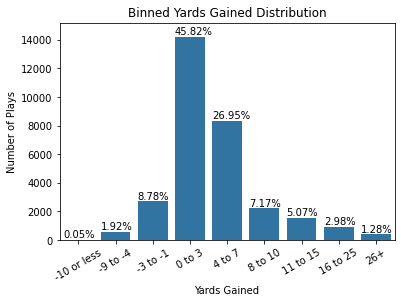

In [12]:
# distribution of binned yards
df = pd.DataFrame(data['yards_binned'].value_counts())
df['yards'] = df.index
order = ['-10 or less', '-9 to -4', '-3 to -1', '0 to 3', '4 to 7', '8 to 10', '11 to 15', '16 to 25', '26+']
df = df.reindex(order)
df['yards_binned'] = df['yards_binned']/22
df['prop'] = round(df['yards_binned']/df['yards_binned'].sum()*100,2)
#print(df)
sns.barplot(x = 'yards', y = 'yards_binned', data = df, color = 'tab:blue')
plt.ylabel('Number of Plays')
plt.xlabel('Yards Gained')
plt.title('Binned Yards Gained Distribution')
plt.xticks(rotation = 30)
for i in np.arange(len(df)):
    plt.text(x = i - 0.4, 
             y = df['yards_binned'][i]+150, 
             s = str(df['prop'][i]) + '%')
plt.ylim(0, df['yards_binned'].max()+1000)
plt.show()
del df

### Get Dummy Variables for Categorical

In [35]:
### Get dummy variables for categorical variables (object type)
num_data = data[cols_to_keep]
num_data = pd.get_dummies(num_data)

## Train and Test Sets

In [28]:
data.fillna(-999, inplace = True)

In [29]:
## use 2017 and 2018 to predict 2019
# don't use dummy variables - only numeric
keep = data[cols_to_keep]
# use dummy variables (models will take longer)
#keep = num_data
# input variables
trainX = keep.loc[keep['season'] != 2019]
testX = keep.loc[keep['season'] == 2019]
# labels
trainY = keep.loc[keep['season'] != 2019]['yards']
testY = keep.loc[keep['season'] == 2019]['yards']
# binned labels
bin_trainY = data.loc[data['season'] != 2019]['yards_bin_int']
bin_testY = data.loc[data['season'] == 2019]['yards_bin_int']
# drop labels from input variables
trainX.drop(['yards', 'avgyardspergame'], axis = 1, inplace = True)
testX.drop(['yards', 'avgyardspergame'], axis = 1, inplace = True)

print('# of Train Plays: {}   # of Test Plays: {}'.format(int(trainX.shape[0]/22), int(testX.shape[0]/22)))
print('# of Train Labels: {}  # of Test Labels: {}'.format(int(trainY.shape[0]/22), int(testY.shape[0]/22)))
print('# of Train Bins: {}  # of Test Bins: {}'.format(int(bin_trainY.shape[0]/22), int(bin_testY.shape[0]/22)))
print('All Plays Covered: {}'.format(trainX.shape[0] + testY.shape[0] == data.shape[0]))

# of Train Plays: 23171   # of Test Plays: 7836
# of Train Labels: 23171  # of Test Labels: 7836
# of Train Bins: 23171  # of Test Bins: 7836
All Plays Covered: True


In [30]:
# drop categorical features - only want numeric
cat_features = []
for col in trainX.columns:
    if (trainX[col].dtype == 'object'):
        cat_features.append(col)
# drop from train and test sets
trainX = trainX.drop(cat_features, axis = 1)
testX = testX.drop(cat_features, axis = 1)


In [9]:
trainX.shape

(509762, 81)

### Normalize 

In [31]:
scaler = MinMaxScaler()
norm_trainX = pd.DataFrame(scaler.fit_transform(trainX), columns = trainX.columns)
norm_testX = pd.DataFrame(scaler.fit_transform(testX), columns = testX.columns)

In [8]:
trainname = 'trainX.pkl'
testname = 'testX.pkl'
pickle.dump(norm_trainX, open(trainname, 'wb'))
pickle.dump(norm_testX, open(testname, 'wb'))

In [32]:
drop_cols = ['rk_19',
 'g_19',
 'gs_19',
 'att_19',
 'yds_19',
 'td_19',
 '1d_19',
 'lng_19',
 'y/a_19',
 'y/g_19',
 'fmb_19']
norm_trainX = trainX.drop(drop_cols, axis = 1)
norm_testX = testX.drop(drop_cols, axis = 1)

In [25]:
# keep all columns with a standard deviation not 0 - only columns
# with variance
players_col = []
for col in norm_trainX.columns:
    if norm_trainX[col][:22].std()!=0:
        players_col.append(col)

In [47]:
players_col

['s',
 'a',
 'dis',
 'orientation',
 'dir',
 'playerheight',
 'playerweight',
 'age',
 'rusher',
 'rushy',
 'disttorush',
 'min_distancetorusher',
 'x_standard',
 'y_standard',
 'x_handoff',
 'y_handoff',
 'offense',
 'eff_downfield_acc',
 'eff_crossfield_acc',
 'playerblocked',
 'rk_17',
 'g_17',
 'gs_17',
 'att_17',
 'yds_17',
 '1d_17',
 'lng_17',
 'y/a_17',
 'y/g_17',
 'fmb_17',
 'rk_18',
 'g_18',
 'gs_18',
 'att_18',
 'yds_18',
 'td_18',
 '1d_18',
 'lng_18',
 'y/a_18',
 'y/g_18',
 'fmb_18',
 'team_away',
 'team_home',
 'playercollegename_Arizona',
 'playercollegename_Auburn',
 'playercollegename_Brigham Young',
 'playercollegename_Colorado',
 'playercollegename_Georgia',
 'playercollegename_Georgia Tech',
 'playercollegename_Miami',
 'playercollegename_Michigan',
 'playercollegename_Mississippi State',
 'playercollegename_Monmouth, N.J.',
 'playercollegename_Newberry',
 'playercollegename_North Carolina State',
 'playercollegename_Oregon',
 'playercollegename_Oregon State',
 'playe

## Evaluation Metrics

### Plot Confusion Matrix

In [0]:
def plot_CM(cm, # confusion_matrix object
            classes, # class labels
            normalize = False, # normalize values
            title = 'Confusion Matrix',
            cmap = 'PuBu'):
  '''
  ouputs: confusion matrix of predicted vs actual labels
  '''
  plt.figure(figsize = (7, 7))
  # plot confusion matrix
  plt.imshow(cm, interpolation = 'nearest', cmap = cmap) 
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation = 90)
  plt.yticks(tick_marks, classes)
  # normalize the values (%)
  if normalize:
    cm = cm.astype('float')/cm.sum(axis = 1)[:, np.newaxis]
    cm = np.round(cm, 2)
  # set threshold for text color
  # if count < half max - white, > half max - black
  thresh = cm.max()/2
  # annotate confusion matrix
  for i,j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i,j],
             horizontalalignment = 'center',
             color = 'white' if cm[i,j] > thresh else 'black')
  plt.tight_layout()
  plt.ylabel('True Label')
  plt.xlabel('Predicted Label')


### Plot Validation and Loss Curves for CNN

In [0]:
# plot train curve function
def plot_train_curve(history):
    # get training accuracy
    accuracy = history.history['accuracy']
    # get test accuracy
    val_accuracy = history.history['val_accuracy']
    # train loss
    loss = history.history['loss']
    # test los
    val_loss = history.history['val_loss']
    # enumerate each epoch 0 to number of ephochs 
    epochs = range(len(accuracy))
        
    plt.figure(figsize = (8, 8/1.618))
    # training accuracy line plot
    plt.plot(epochs, accuracy, marker = 'o', 
             c = 'tab:orange', label = 'Training accuracy')
    # test accuracy line plot
    plt.plot(epochs, val_accuracy, marker = 'D', 
             c = 'tab:blue', label = 'Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.xlim(0, len(epochs))
    plt.legend()
    plt.figure(figsize = (8, 8/1.618))
    # training loss line plot
    plt.plot(epochs, loss, marker = 'o', 
             c = 'tab:orange', label = 'Training loss')
    # test loss line plot
    plt.plot(epochs, val_loss, marker = 'D', 
             c = 'tab:blue', label = 'Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.xlim(0,len(epochs))
    plt.legend()
    plt.show()

# Convolutional Neural Network
Requires Binned Yards for Prediction

## Reshape Data

In [0]:
from keras.utils import np_utils # categorical variable

In [0]:
# reshape the train and test sets to be arrays 
# shape of array should be # of plays by number of features kept * 22
cnn_trainX = np.array(trainX[players_col]).reshape(-1, len(players_col)*22)
cnn_testX = np.array(testX[players_col]).reshape(-1, len(players_col)*22)
print(cnn_trainX.shape)
print(cnn_testX.shape)


(23171, 1276)
(7836, 1276)


In [0]:
# gets all the columns that are used as features
play_col = trainX.drop(players_col, axis = 1).columns
# generate an array of 0s that is number of plays by number of features
xtrain_play_col = np.zeros(shape = (cnn_trainX.shape[0], len(play_col)))
xtest_play_col = np.zeros(shape = (cnn_testX.shape[0], len(play_col)))
# fill in the array
for i, col in enumerate(play_col):
  xtrain_play_col[:, i] = trainX[col][::22]
  xtest_play_col[:, i] = testX[col][::22]

In [0]:
# put together training array with features
cnn_trainX = np.concatenate([cnn_trainX, xtrain_play_col], axis = 1)
cnn_testX = np.concatenate([cnn_testX, xtest_play_col], axis = 1)
# create the label arrays
# create an array of zeros of shape number of plays by 9 - number of bins
# use [::22] to get all rows and cols but count by 22 (play level)
# all yards
cnn_trainY = np_utils.to_categorical(trainY)[::22]
cnn_testY = np_utils.to_categorical(testY)[::22]
# binned yard labels
bin_cnn_trainY = np_utils.to_categorical(bin_trainY)[::22]
bin_cnn_testY = np_utils.to_categorical(bin_testY)[::22]


In [0]:
#from sklearn.preprocessing import MinMaxScaler # normalizing
# normalize the data to be between 0 and 1
scaler = MinMaxScaler()
cnn_trainX = scaler.fit_transform(cnn_trainX)
cnn_testX = scaler.fit_transform(cnn_testX)
#norm_data = pd.DataFrame(scaler.fit_transform(num_data), 
 #                       columns = num_data.columns)

In [0]:
print('train set: ', cnn_trainX.shape)
print('train labels: ', bin_cnn_trainY.shape)
print('test set: ', cnn_testX.shape)
print('test labels: ', bin_cnn_testY.shape)

train set:  (23171, 5518)
train labels:  (23171, 9)
test set:  (7836, 5518)
test labels:  (7836, 9)


## Define the Model

In [0]:
def get_model():
    x = keras.layers.Input(shape=[cnn_trainX.shape[1]])
    # convolution layer 1
    fc1 = keras.layers.Dense(units = 450, input_shape=[cnn_trainX.shape[1]])(x)
    # activation function (relu)
    act1 = keras.layers.PReLU()(fc1)
    # batch normalization
    bn1 = keras.layers.BatchNormalization()(act1)
    # randomly drop 55% of neurons
    dp1 = keras.layers.Dropout(0.55)(bn1)
    # augment data to avoid overfitting
    gn1 = keras.layers.GaussianNoise(0.15)(dp1)
    # join it together
    concat1 = keras.layers.Concatenate()([x, gn1])
    # convolution layer 2
    fc2 = keras.layers.Dense(units = 600)(concat1)
    # activation function (relu)
    act2 = keras.layers.PReLU()(fc2)
    # batch normalization
    bn2 = keras.layers.BatchNormalization()(act2)
    # randomly drop 55% of neurons
    dp2 = keras.layers.Dropout(0.55)(bn2)
    # augment data to avoid overfitting
    gn2 = keras.layers.GaussianNoise(0.15)(dp2)
    # join the layer together
    concat2 = keras.layers.Concatenate()([concat1, gn2])
    # convolution layer 3
    fc3 = keras.layers.Dense(units=400)(concat2)
    act3 = keras.layers.PReLU()(fc3)
    bn3 = keras.layers.BatchNormalization()(act3)
    dp3 = keras.layers.Dropout(0.55)(bn3)
    gn3 = keras.layers.GaussianNoise(0.15)(dp3)
    concat3 = keras.layers.Concatenate([concat2, gn3])
    # final fully connected layer
    # use softmax activation for predictions
    output = keras.layers.Dense(units = 9, activation = 'softmax')(concat2)
    model = keras.models.Model(inputs = [x], outputs = [output])
    return model


## Compile and Fit the Model

In [0]:
# define the model
bin_model = get_model()
# compile the model
bin_model.compile(optimizer = RAdam(warmup_proportion = 0.1, min_lr = 0.001), 
                  loss = 'categorical_crossentropy',
                  metrics = ['accuracy'])
# define an early stopping feature 
er = EarlyStopping(patience = 20, # stops after 20 epochs with no decrease in loss
                      min_delta = 0.001, # minimum change in loss to keep running 
                       restore_best_weights = True, 
                       monitor = 'val_loss')
batch_size = 100 # put in 100 plays at a time
# fit the model on the train set and use it on validation set
history = bin_model.fit(cnn_trainX, bin_cnn_trainY, epochs = 200, 
              callbacks = [er], 
              validation_data = [cnn_testX, bin_cnn_testY],
              verbose = 2, 
              batch_size = batch_size)


Train on 23171 samples, validate on 7836 samples
Epoch 1/200
 - 3s - loss: 2.4030 - accuracy: 0.1334 - val_loss: 2.1149 - val_accuracy: 0.2014
Epoch 2/200
 - 2s - loss: 2.4030 - accuracy: 0.1353 - val_loss: 2.1377 - val_accuracy: 0.1893
Epoch 3/200
 - 2s - loss: 2.4047 - accuracy: 0.1373 - val_loss: 2.1796 - val_accuracy: 0.1736
Epoch 4/200
 - 2s - loss: 2.4109 - accuracy: 0.1339 - val_loss: 2.1927 - val_accuracy: 0.1688
Epoch 5/200
 - 2s - loss: 2.3944 - accuracy: 0.1381 - val_loss: 2.1981 - val_accuracy: 0.1644
Epoch 6/200
 - 2s - loss: 2.4107 - accuracy: 0.1322 - val_loss: 2.1929 - val_accuracy: 0.1690
Epoch 7/200
 - 2s - loss: 2.4096 - accuracy: 0.1326 - val_loss: 2.1987 - val_accuracy: 0.1651
Epoch 8/200
 - 2s - loss: 2.4160 - accuracy: 0.1329 - val_loss: 2.1955 - val_accuracy: 0.1665
Epoch 9/200
 - 2s - loss: 2.4068 - accuracy: 0.1354 - val_loss: 2.1983 - val_accuracy: 0.1649
Epoch 10/200
 - 2s - loss: 2.4020 - accuracy: 0.1337 - val_loss: 2.1926 - val_accuracy: 0.1695
Epoch 11/2

In [0]:
# get accuracy and loss scores from the model
score = bin_model.evaluate(cnn_testX, bin_cnn_testY)
# store accuracy
cnn_acc = round(score[1],4)
#t1 = time.time()
print('loss: {}'.format(round(score[0],4)))
print('accuracy: {}'.format(round(score[1], 4)))

7836/7836 [==============================] - 1s 92us/step
loss: 2.1149
accuracy: 0.2014


### Accuracy and Loss Curves

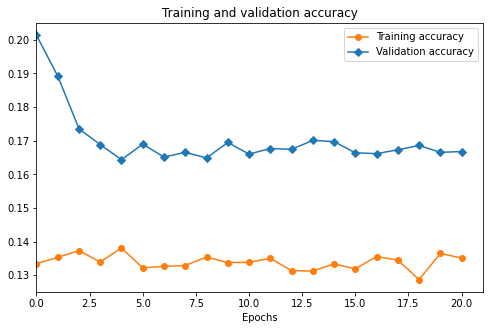

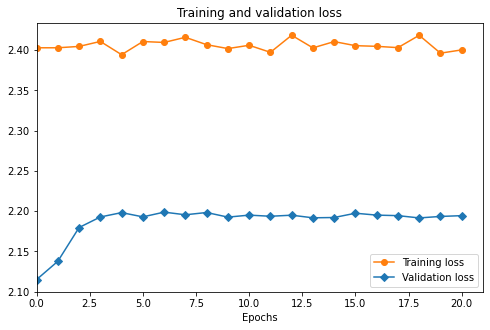

In [0]:
# print accuraccy and loss curves
plot_train_curve(history)

### Confusion Matrix for CNN

              precision    recall  f1-score   support

 -10 or less       0.00      0.00      0.00         3
    -9 to -4       0.05      0.01      0.01       126
    -3 to -1       0.08      0.03      0.04       639
      0 to 3       0.47      0.33      0.39      3657
      4 to 7       0.29      0.12      0.17      2124
     8 to 10       0.08      0.05      0.06       573
    11 to 15       0.06      0.05      0.06       394
    16 to 25       0.03      0.10      0.05       226
         26+       0.01      0.30      0.02        94

    accuracy                           0.20      7836
   macro avg       0.12      0.11      0.09      7836
weighted avg       0.32      0.20      0.24      7836



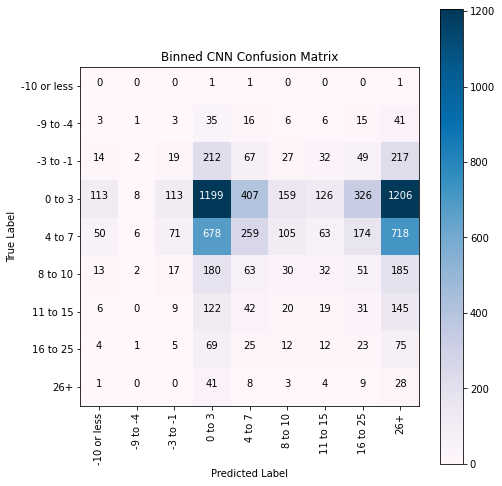

In [0]:
# predict values from test set
y_bin_pred = bin_model.predict(cnn_testX)
# convert predictions classes to one hot vectors
y_bin_pred_classes = np.argmax(y_bin_pred, axis = 1)
# convert test labels to one hot vectors
y_bin_true = np.argmax(bin_cnn_testY, axis = 1)
# compute confusion matrix
cm = confusion_matrix(y_bin_true, y_bin_pred_classes)
# plot confusion matrix
plot_CM(cm = cm, 
        classes = bin_yard_names,
        normalize = False,
        title = 'Binned CNN Confusion Matrix')
print(classification_report(y_bin_true, y_bin_pred_classes,
                            target_names = bin_yard_names))

# Random Forest Classifier

In [0]:
players_col
#norm_trainX.head()

### Selected Variables

In [33]:
var = ['s', 'a', 'distance', 'playerheight', 'time_since_snap', 'x_standard', \
               'y_standard', 'disttorush', 'min_distancetorusher', 'yardfromowngoal', 'eff_downfield_acc', \
               'eff_crossfield_acc', 'gameclock', 'down', 'defendersinthebox', 'eff_18', 'tlos_18',\
               'playerblocked']
var2 = ['gameclock',
 'rushx',
 'min_distancetorusher',
 'yardfromowngoal',
 'yardline',
 'x_standard',
 'x_handoff',
 'eff_crossfield_acc',
 'y_handoff',
 'dir',
 'y_standard',
 's',
 'distance',
 'orientation',
 'eff_downfield_acc']

## All Variables

In [48]:
#### ALL REMAINING VARIABLES
## using var1 - top features when rf is run with all variables
# predict binned yards
import time
t0 = time.time()
bin_rf_clf_all = RandomForestClassifier(n_estimators = 100, # number of trees
                           min_samples_split = 3,
                           oob_score = True)
bin_rf_clf_all.fit(norm_trainX, bin_trainY)
t1 = time.time()
print('Total time (min): ', round((t1-t0)/60,2))
print('Accuracy: ', round(bin_rf_clf_all.score(norm_testX, bin_testY)*100,2), '%')

Total time (sec):  305.18
Accuracy:  100.0 %


## Select Variables - hypothesized to be impactful

In [32]:
# predict binned yards
tr_X1 = norm_trainX[var]
tst_X1 = norm_testX[var]
bin_rf_clf = RandomForestClassifier(n_estimators = 100, # number of trees
                           min_samples_split = 3,
                           oob_score = True)
bin_rf_clf.fit(tr_X1, bin_trainY)
print('Accuracy: ', round(bin_rf_clf.score(tst_X1, bin_testY)*100,2), '%')


Accuracy:  33.78 %


## 15 Most important variables from all variables

In [40]:
## using var1 - top features when rf is run with all variables
# predict binned yards
tr_X2 = norm_trainX[var2]
tst_X2 = norm_testX[var2]
bin_rf_clf2 = RandomForestClassifier(n_estimators = 500, # number of trees
                           min_samples_split = 10,
                            #max_features = 15,
                           oob_score = True)
bin_rf_clf2.fit(tr_X2, bin_trainY)
print('Accuracy: ', round(bin_rf_clf2.score(tst_X2, bin_testY)*100,2), '%')


KeyboardInterrupt: 

In [ ]:
# predictions
y_pred = bin_rf_clf2.predict(tst_X2)
# define confusion matrix
cm = confusion_matrix(bin_testY, y_pred)
# plot cm as a heat map
plt.figure(figsize = (8,8))
sns.heatmap(cm, annot = True, cmap = 'PuBu', fmt = 'd') # fmt = 'd' prints integers
plt.title('Random Forest Classifier Confusion Matrix')
plt.ylabel('True Values')
plt.xlabel('Predicted Values')
plt.xticks(np.arange(0.5,9.5), labels = bin_yard_names, rotation = 90)
plt.yticks(np.arange(0.5,9.5), labels = bin_yard_names, rotation = 0)
plt.show()


In [ ]:
print(classification_report(bin_testY, y_pred, target_names = bin_yard_names, zero_division = 0))



In [14]:
tr_X2 = trainX[var2]
tst_X2 = testX[var2]

### Save the train/test sets with hightest accuracy

In [35]:
trainname = 'trainX.pkl'
testname = 'testX.pkl'
pickle.dump(tr_X2, open(trainname, 'wb'))
pickle.dump(tst_X2, open(testname, 'wb'))

In [36]:
## Save the model
modelname = 'rf_model.sav'
pickle.dump(bin_rf_clf2, open(modelname, 'wb'))

### Confusion Matrix

#### var

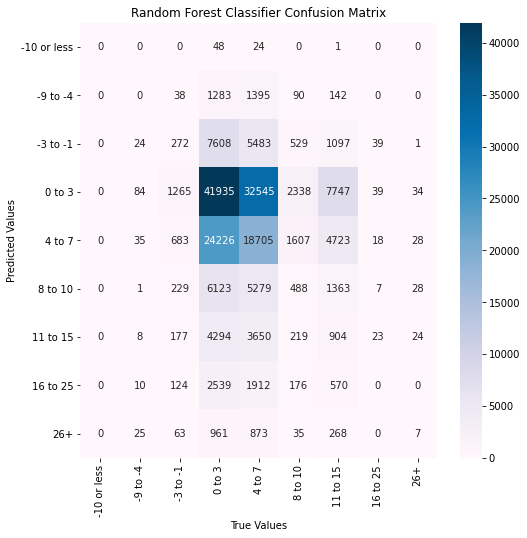

In [33]:
# predictions
y_pred = bin_rf_clf.predict(tst_X1)
# define confusion matrix
cm = confusion_matrix(bin_testY, y_pred)
# plot cm as a heat map
plt.figure(figsize = (8,8))
sns.heatmap(cm, annot = True, cmap = 'PuBu', fmt = 'd') # fmt = 'd' prints integers
plt.title('Random Forest Classifier Confusion Matrix')
plt.ylabel('True Values')
plt.xlabel('Predicted Values')
plt.xticks(np.arange(0.5,9.5), labels = bin_yard_names, rotation = 90)
plt.yticks(np.arange(0.5,9.5), labels = bin_yard_names, rotation = 0)
plt.show()

#### var2

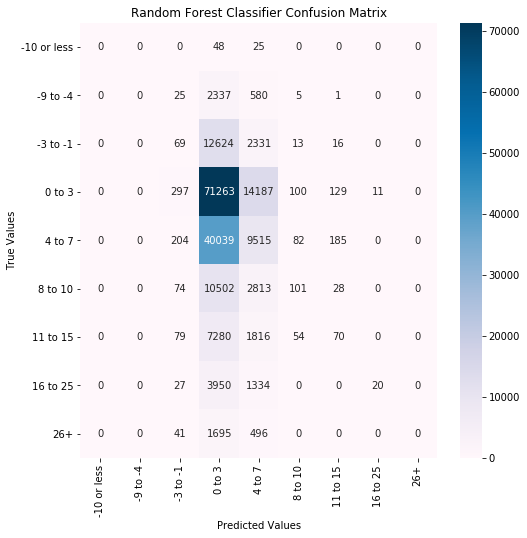

In [15]:
# predictions
y_pred2 = bin_rf_clf2.predict(tst_X2)
# define confusion matrix
cm = confusion_matrix(bin_testY, y_pred2)
# plot cm as a heat map
plt.figure(figsize = (8,8))
sns.heatmap(cm, annot = True, cmap = 'PuBu', fmt = 'd') # fmt = 'd' prints integers
plt.title('Random Forest Classifier Confusion Matrix')
plt.ylabel('True Values')
plt.xlabel('Predicted Values')
plt.xticks(np.arange(0.5,9.5), labels = bin_yard_names, rotation = 90)
plt.yticks(np.arange(0.5,9.5), labels = bin_yard_names, rotation = 0)
plt.show()

### Classification Report

#### var

In [34]:
print(classification_report(bin_testY, y_pred, target_names = bin_yard_names, zero_division = 0))

              precision    recall  f1-score   support

 -10 or less       0.00      0.00      0.00        73
    -9 to -4       0.00      0.00      0.00      2948
    -3 to -1       0.10      0.02      0.03     15053
      0 to 3       0.47      0.49      0.48     85987
      4 to 7       0.27      0.37      0.31     50025
     8 to 10       0.09      0.04      0.05     13518
    11 to 15       0.05      0.10      0.07      9299
    16 to 25       0.00      0.00      0.00      5331
         26+       0.06      0.00      0.01      2232

    accuracy                           0.34    184466
   macro avg       0.11      0.11      0.11    184466
weighted avg       0.31      0.34      0.32    184466



#### var2

In [14]:
print(classification_report(bin_testY, y_pred2, target_names = bin_yard_names, zero_division = 0))

              precision    recall  f1-score   support

 -10 or less       0.00      0.00      0.00        73
    -9 to -4       0.00      0.00      0.00      2948
    -3 to -1       0.12      0.01      0.01     15053
      0 to 3       0.48      0.82      0.60     85987
      4 to 7       0.28      0.19      0.23     50025
     8 to 10       0.09      0.00      0.00     13518
    11 to 15       0.04      0.00      0.00      9299
    16 to 25       0.49      0.00      0.01      5331
         26+       0.00      0.00      0.00      2232

    accuracy                           0.44    184466
   macro avg       0.17      0.11      0.10    184466
weighted avg       0.33      0.44      0.34    184466



### Most Important Features

#### var

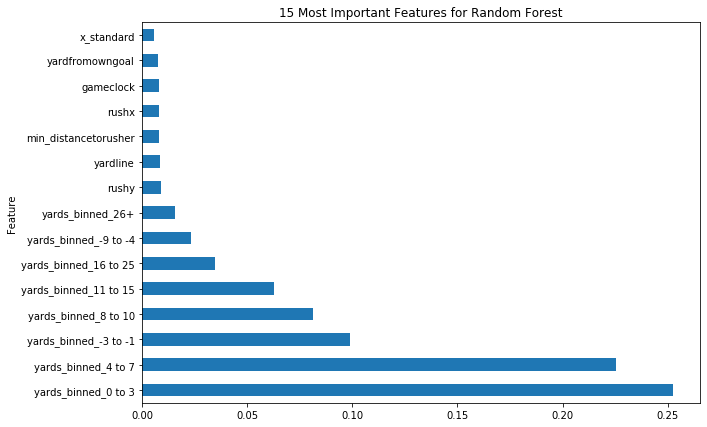

Features
yards_binned_0 to 3      0.252696
yards_binned_4 to 7      0.225377
yards_binned_-3 to -1    0.098841
yards_binned_8 to 10     0.081175
yards_binned_11 to 15    0.062694
yards_binned_16 to 25    0.034796
yards_binned_-9 to -4    0.023464
yards_binned_26+         0.015740
rushy                    0.008828
yardline                 0.008494
min_distancetorusher     0.008305
rushx                    0.008275
gameclock                0.008218
yardfromowngoal          0.007815
x_standard               0.005563
dtype: float64


In [60]:
## Print n most important features
n = 15
plt.figure(figsize = (10, 7))
# impurity-based feature importance
importances = pd.Series(bin_rf_clf2.feature_importances_, index = norm_trainX.columns)
# sort values in descending order
importances = importances.sort_values(ascending = False)
# horizontal barplot
importances.nlargest(n).plot(kind = 'barh')
plt.title('{} Most Important Features for Random Forest'.format(n))
plt.ylabel('Feature')
plt.show()
print('Features')
print(importances[:n])

In [53]:
rmse = np.sqrt(mean_squared_error(bin_testY, y_pred2))
rmse = round(rmse,2)
rmse

1.36

#### var2

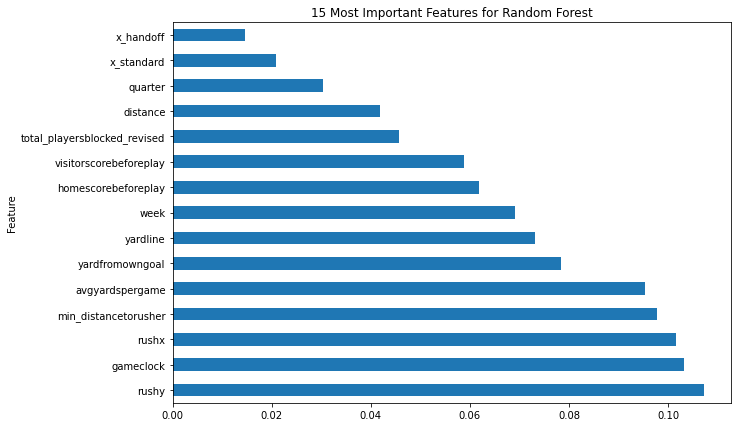

Features
rushy                           0.107269
gameclock                       0.103210
rushx                           0.101683
min_distancetorusher            0.097755
avgyardspergame                 0.095387
yardfromowngoal                 0.078413
yardline                        0.073093
week                            0.069049
homescorebeforeplay             0.061892
visitorscorebeforeplay          0.058909
total_playersblocked_revised    0.045732
distance                        0.041768
quarter                         0.030322
x_standard                      0.020884
x_handoff                       0.014635
dtype: float64


In [15]:
## Print n most important features
n = len(var2)
plt.figure(figsize = (10, 7))
# impurity-based feature importance
importances = pd.Series(bin_rf_clf2.feature_importances_, index = tr_X2.columns)
# sort values in descending order
importances = importances.sort_values(ascending = False)
# horizontal barplot
importances.nlargest(n).plot(kind = 'barh')
plt.title('{} Most Important Features for Random Forest'.format(n))
plt.ylabel('Feature')
plt.show()
print('Features')
print(importances[:n])

In [0]:
# predictions to use = y_pred2
testX.index

In [16]:
preds = pd.DataFrame(zip(bin_testY, y_pred2), columns = ['true', 'pred'], index = testX.index)
len(preds)

184466

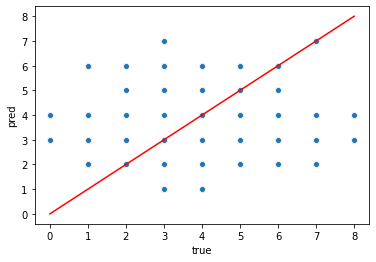

In [17]:
sns.scatterplot(x = 'true', y = 'pred', data = preds)
plt.plot(np.arange(9), np.arange(9), color = 'red')
plt.show()

In [0]:
df = data.iloc[list(preds.index)]

In [19]:
df['pred'] = preds['pred']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [0]:
correct = df.loc[df['yards_bin_int'] == df['pred']]

In [63]:
# distribution of formation in correct predictions
ofplot = correct[['offenseformation']]
ofplot['count'] = 1
ofplot = round(ofplot.groupby('offenseformation').sum()/22).astype(int)
ofplot = ofplot.sort_values('count', ascending = False)
ofplot['pct'] = round(ofplot/ofplot.sum()*100,2)
# distribution of formation in whole data
form = data[['offenseformation']]
form['count'] = 1
form = round(form.groupby('offenseformation').sum()/22).astype(int)
form = form.sort_values('count', ascending = False)
form_pct = round(form/form.sum()*100,2)
form_pct['formation'] = form_pct.index



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [64]:
ofplot['formation'] = ofplot.index
new_row = {'formation':'ACE', 'count':0, 'pct':0.0}
ofplot = ofplot.append(new_row, ignore_index = True)
ofplot

,count,pct,formation
0,1560,42.60,SINGLEBACK
1,1153,31.49,SHOTGUN
2,677,18.49,I_FORM
3,152,4.15,PISTOL
4,110,3.00,JUMBO
5,6,0.16,WILDCAT
6,4,0.11,EMPTY
7,0,0.00,ACE


In [67]:
#form_pct.index = range(len(form_pct))
form_pct

,count,formation
0,44.04,SINGLEBACK
1,30.12,SHOTGUN
2,20.13,I_FORM
3,3.15,PISTOL
4,2.19,JUMBO
5,0.25,WILDCAT
6,0.10,EMPTY
7,0.01,-999
8,0.00,ACE


In [0]:
form_pct = form_pct.drop(7)
ofplot['total_pct'] = form_pct['count']

In [70]:
ofplot['total_pct'][7] = 0.0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,count,pct,formation,total_pct
0,1560,42.60,SINGLEBACK,44.04
1,1153,31.49,SHOTGUN,30.12
2,677,18.49,I_FORM,20.13
3,152,4.15,PISTOL,3.15
4,110,3.00,JUMBO,2.19
5,6,0.16,WILDCAT,0.25
6,4,0.11,EMPTY,0.10
7,0,0.00,ACE,0.00


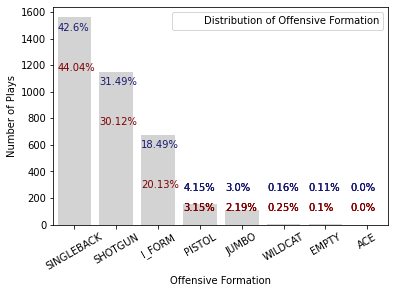

In [89]:
from matplotlib.patches import Rectangle
sns.barplot(x = 'formation', y = 'count', 
            data = ofplot, color = 'lightgray')
for i in np.arange(3):
  plt.text(x = i - 0.4,
           y = ofplot['count'][i] - 100,
           s = str(ofplot['pct'][i])+'%',
           color = 'midnightblue',
           label = '% of Correctly Predicted Plays')
  plt.text(x = i - 0.4,
           y = ofplot['count'][i] - 400,
           s = str(ofplot['total_pct'][i])+'%',
           color = 'maroon', 
           label = '% of Total Plays')
  for i in np.arange(3,8):
    plt.text(x = i-0.4,
             y = 250,
             s = str(ofplot['pct'][i])+'%',
             color = 'midnightblue')
    plt.text(x = i - 0.4,
             y = 100,
             s = str(ofplot['total_pct'][i])+'%',
             color = 'maroon')
plt.title('Distribution of Offensive Formations')
plt.xticks(rotation = 30)
plt.xlabel('Offensive Formation')
plt.ylabel('Number of Plays')
plt.show()

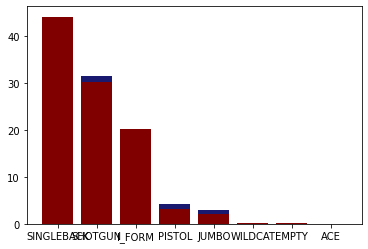

In [90]:
fig = plt.figure()
ax = fig.add_subplot(111)
bar_pct = ax.bar(ofplot['formation'], ofplot['pct'], color = 'midnightblue')
bar_total_pct = ax.bar(ofplot['formation'], ofplot['total_pct'], color = 'maroon')
plt.show()

In [0]:
form = data[['offenseformation']]
form['count'] = 1
form = form.groupby('count').sum()
form = form.sort_values('count', ascending = False)
form

In [105]:
ofplot

,count,pct,formation,total_pct
0,1560,42.60,SINGLEBACK,44.04
1,1153,31.49,SHOTGUN,30.12
2,677,18.49,I_FORM,20.13
3,152,4.15,PISTOL,3.15
4,110,3.00,JUMBO,2.19
5,6,0.16,WILDCAT,0.25
6,4,0.11,EMPTY,0.10
7,0,0.00,ACE,0.00


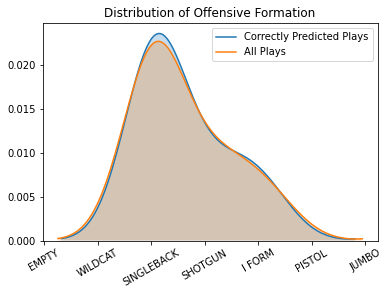

In [112]:
sns.kdeplot(ofplot['pct'], shade = True)
sns.kdeplot(ofplot['total_pct'], shade = True)
plt.legend(labels = ['Correctly Predicted Plays', 'All Plays'])
plt.title('Distribution of Offensive Formation')
plt.xticks(ticks = np.arange(-40, 100, 20),labels = ['EMPTY','WILDCAT', 'SINGLEBACK', 'SHOTGUN', 'I FORM', 'PISTOL', 'JUMBO'], rotation = 30)
plt.show()

In [101]:
correct.head()

,gameid,playid,team,x,y,s,a,dis,orientation,dir,nflid,displayname,jerseynumber,season,yardline,quarter,gameclock,possessionteam,down,distance,fieldposition,homescorebeforeplay,visitorscorebeforeplay,nflidrusher,offenseformation,offensepersonnel,defendersinthebox,defensepersonnel,playdirection,timehandoff,timesnap,yards,playerheight,playerweight,playerbirthdate,playercollegename,position,hometeamabbr,visitorteamabbr,week,...,2_sec_y,2_5_sec_y,3_sec_y,3_5_sec_y,4_sec_y,4_5_sec_y,5_sec_y,5_5_sec_y,6_sec_y,offense,eff_downfield_acc,eff_crossfield_acc,rushteamwinning,playerblocked,total_playersblocked,total_playersblocked_revised,yards_binned,eff_17,8+d%_17,tlos_17,att_17,yds_17,avg_17,td_17,eff_18,8+d%_18,tlos_18,att_18,yds_18,avg_18,td_18,eff_19,8+d%_19,tlos_19,att_19,yds_19,avg_19,td_19,yards_bin_int,pred
553953,2019090500,20190905000050,away,34.32,24.27,5.09,1.95,0.50,52.07,70.69,496988,Bryan Bulaga,75,2019,25,1,900.0,CHI,1,10,GB,0,0,2558116,I_FORM,"2 RB, 1 TE, 2 WR",7.0,"3 DL, 4 LB, 4 DB",right,2019-09-06 00:23:35+00:00,2019-09-06 00:23:34+00:00,0,77,314,1989-03-21,Iowa,OT,CHI,GB,1,...,37.557905,42.030068,46.962306,52.354619,53.30000,53.300000,53.300000,53.300000,53.300000,0,0.644824,1.840299,0,0,7,7,0 to 3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,3
553954,2019090500,20190905000050,away,33.13,30.92,3.59,2.06,0.36,20.13,102.04,2495888,Marcedes Lewis,89,2019,25,1,900.0,CHI,1,10,GB,0,0,2558116,I_FORM,"2 RB, 1 TE, 2 WR",7.0,"3 DL, 4 LB, 4 DB",right,2019-09-06 00:23:35+00:00,2019-09-06 00:23:34+00:00,0,78,267,1984-05-19,UCLA,TE,CHI,GB,1,...,41.971425,45.993459,50.519164,53.300000,53.30000,53.300000,53.300000,53.300000,53.300000,0,-0.429705,2.014685,0,0,7,7,0 to 3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,3
553955,2019090500,20190905000050,away,30.68,24.69,3.84,2.41,0.38,271.54,177.64,2506363,Aaron Rodgers,12,2019,25,1,900.0,CHI,1,10,GB,0,0,2558116,I_FORM,"2 RB, 1 TE, 2 WR",7.0,"3 DL, 4 LB, 4 DB",right,2019-09-06 00:23:35+00:00,2019-09-06 00:23:34+00:00,0,74,225,1983-12-02,California,QB,CHI,GB,1,...,25.204727,25.395433,25.610949,25.851275,26.11641,26.406356,26.721111,27.060676,27.425051,0,-2.407956,0.099239,0,0,7,7,0 to 3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,3
553956,2019090500,20190905000050,away,34.82,30.70,4.65,1.25,0.48,46.80,84.83,2540183,David Bakhtiari,69,2019,25,1,900.0,CHI,1,10,GB,0,0,2558116,I_FORM,"2 RB, 1 TE, 2 WR",7.0,"3 DL, 4 LB, 4 DB",right,2019-09-06 00:23:35+00:00,2019-09-06 00:23:34+00:00,0,76,310,1991-09-30,Colorado,T,CHI,GB,1,...,42.451994,46.168064,50.195363,53.300000,53.30000,53.300000,53.300000,53.300000,53.300000,0,0.112639,1.244915,0,0,7,7,0 to 3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,3
553957,2019090500,20190905000050,away,34.22,29.19,4.80,0.87,0.49,57.18,81.39,2541898,Lane Taylor,65,2019,25,1,900.0,CHI,1,10,GB,0,0,2558116,I_FORM,"2 RB, 1 TE, 2 WR",7.0,"3 DL, 4 LB, 4 DB",right,2019-09-06 00:23:35+00:00,2019-09-06 00:23:34+00:00,0,75,324,1989-11-22,Oklahoma State,G,CHI,GB,1,...,40.402201,43.742874,47.298595,51.069365,53.30000,53.300000,53.300000,53.300000,53.300000,0,0.130246,0.860195,0,0,7,7,0 to 3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,3


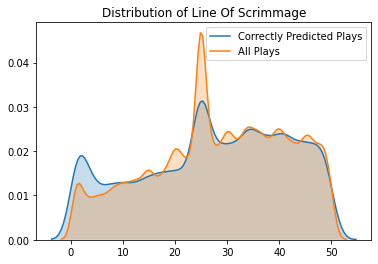

In [113]:
sns.kdeplot(correct['yardline'], shade = True)
sns.kdeplot(data['yardline'], shade = True)
plt.legend(labels = ['Correctly Predicted Plays', 'All Plays'])
plt.title('Distribution of Line Of Scrimmage')
plt.show()

KeyboardInterrupt: ignored

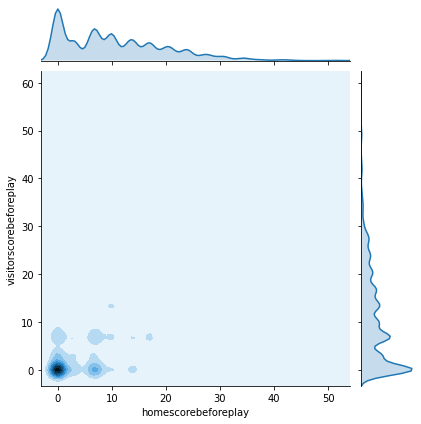

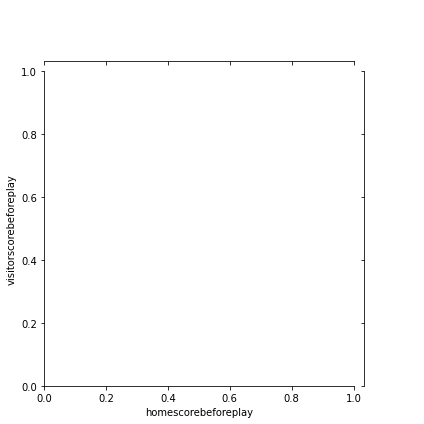

In [116]:
sns.jointplot(x = 'homescorebeforeplay',
             y = 'visitorscorebeforeplay',
             data = correct,
             kind = 'kde')
sns.jointplot(x = 'homescorebeforeplay',
             y = 'visitorscorebeforeplay',
             data = data,
             kind = 'kde')
plt.show()

In [119]:
cor_rush = correct.loc[correct['rusher'] == 1]
pos = cor_rush['position']
p = pd.DataFrame(pos.value_counts())
p['pct'] = round(p/p.sum()*100,2)
p

,position,pct
RB,7993,94.88
HB,355,4.21
WR,44,0.52
FB,15,0.18
QB,11,0.13
TE,5,0.06
G,1,0.01


In [120]:
rusher = data.loc[data['rusher'] == 1]
all_pos = rusher['position']
ap = pd.DataFrame(all_pos.value_counts())
ap['pct'] = round(ap/ap.sum()*100,2)
ap

,position,pct
RB,80137,95.19
HB,2848,3.38
WR,828,0.98
FB,209,0.25
QB,99,0.12
TE,48,0.06
CB,10,0.01
DT,2,0.00
G,1,0.00
DE,1,0.00


In [123]:
correct.head()

,gameid,playid,team,x,y,s,a,dis,orientation,dir,nflid,displayname,jerseynumber,season,yardline,quarter,gameclock,possessionteam,down,distance,fieldposition,homescorebeforeplay,visitorscorebeforeplay,nflidrusher,offenseformation,offensepersonnel,defendersinthebox,defensepersonnel,playdirection,timehandoff,timesnap,yards,playerheight,playerweight,playerbirthdate,playercollegename,position,hometeamabbr,visitorteamabbr,week,...,2_sec_y,2_5_sec_y,3_sec_y,3_5_sec_y,4_sec_y,4_5_sec_y,5_sec_y,5_5_sec_y,6_sec_y,offense,eff_downfield_acc,eff_crossfield_acc,rushteamwinning,playerblocked,total_playersblocked,total_playersblocked_revised,yards_binned,eff_17,8+d%_17,tlos_17,att_17,yds_17,avg_17,td_17,eff_18,8+d%_18,tlos_18,att_18,yds_18,avg_18,td_18,eff_19,8+d%_19,tlos_19,att_19,yds_19,avg_19,td_19,yards_bin_int,pred
553953,2019090500,20190905000050,away,34.32,24.27,5.09,1.95,0.50,52.07,70.69,496988,Bryan Bulaga,75,2019,25,1,900.0,CHI,1,10,GB,0,0,2558116,I_FORM,"2 RB, 1 TE, 2 WR",7.0,"3 DL, 4 LB, 4 DB",right,2019-09-06 00:23:35+00:00,2019-09-06 00:23:34+00:00,0,77,314,1989-03-21,Iowa,OT,CHI,GB,1,...,37.557905,42.030068,46.962306,52.354619,53.30000,53.300000,53.300000,53.300000,53.300000,0,0.644824,1.840299,0,0,7,7,0 to 3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,3
553954,2019090500,20190905000050,away,33.13,30.92,3.59,2.06,0.36,20.13,102.04,2495888,Marcedes Lewis,89,2019,25,1,900.0,CHI,1,10,GB,0,0,2558116,I_FORM,"2 RB, 1 TE, 2 WR",7.0,"3 DL, 4 LB, 4 DB",right,2019-09-06 00:23:35+00:00,2019-09-06 00:23:34+00:00,0,78,267,1984-05-19,UCLA,TE,CHI,GB,1,...,41.971425,45.993459,50.519164,53.300000,53.30000,53.300000,53.300000,53.300000,53.300000,0,-0.429705,2.014685,0,0,7,7,0 to 3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,3
553955,2019090500,20190905000050,away,30.68,24.69,3.84,2.41,0.38,271.54,177.64,2506363,Aaron Rodgers,12,2019,25,1,900.0,CHI,1,10,GB,0,0,2558116,I_FORM,"2 RB, 1 TE, 2 WR",7.0,"3 DL, 4 LB, 4 DB",right,2019-09-06 00:23:35+00:00,2019-09-06 00:23:34+00:00,0,74,225,1983-12-02,California,QB,CHI,GB,1,...,25.204727,25.395433,25.610949,25.851275,26.11641,26.406356,26.721111,27.060676,27.425051,0,-2.407956,0.099239,0,0,7,7,0 to 3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,3
553956,2019090500,20190905000050,away,34.82,30.70,4.65,1.25,0.48,46.80,84.83,2540183,David Bakhtiari,69,2019,25,1,900.0,CHI,1,10,GB,0,0,2558116,I_FORM,"2 RB, 1 TE, 2 WR",7.0,"3 DL, 4 LB, 4 DB",right,2019-09-06 00:23:35+00:00,2019-09-06 00:23:34+00:00,0,76,310,1991-09-30,Colorado,T,CHI,GB,1,...,42.451994,46.168064,50.195363,53.300000,53.30000,53.300000,53.300000,53.300000,53.300000,0,0.112639,1.244915,0,0,7,7,0 to 3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,3
553957,2019090500,20190905000050,away,34.22,29.19,4.80,0.87,0.49,57.18,81.39,2541898,Lane Taylor,65,2019,25,1,900.0,CHI,1,10,GB,0,0,2558116,I_FORM,"2 RB, 1 TE, 2 WR",7.0,"3 DL, 4 LB, 4 DB",right,2019-09-06 00:23:35+00:00,2019-09-06 00:23:34+00:00,0,75,324,1989-11-22,Oklahoma State,G,CHI,GB,1,...,40.402201,43.742874,47.298595,51.069365,53.30000,53.300000,53.300000,53.300000,53.300000,0,0.130246,0.860195,0,0,7,7,0 to 3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,3


In [124]:
zero_to_three = correct.loc[correct['yards_bin_int'] == 3]
zero_to_three.head()

,gameid,playid,team,x,y,s,a,dis,orientation,dir,nflid,displayname,jerseynumber,season,yardline,quarter,gameclock,possessionteam,down,distance,fieldposition,homescorebeforeplay,visitorscorebeforeplay,nflidrusher,offenseformation,offensepersonnel,defendersinthebox,defensepersonnel,playdirection,timehandoff,timesnap,yards,playerheight,playerweight,playerbirthdate,playercollegename,position,hometeamabbr,visitorteamabbr,week,...,2_sec_y,2_5_sec_y,3_sec_y,3_5_sec_y,4_sec_y,4_5_sec_y,5_sec_y,5_5_sec_y,6_sec_y,offense,eff_downfield_acc,eff_crossfield_acc,rushteamwinning,playerblocked,total_playersblocked,total_playersblocked_revised,yards_binned,eff_17,8+d%_17,tlos_17,att_17,yds_17,avg_17,td_17,eff_18,8+d%_18,tlos_18,att_18,yds_18,avg_18,td_18,eff_19,8+d%_19,tlos_19,att_19,yds_19,avg_19,td_19,yards_bin_int,pred
553953,2019090500,20190905000050,away,34.32,24.27,5.09,1.95,0.50,52.07,70.69,496988,Bryan Bulaga,75,2019,25,1,900.0,CHI,1,10,GB,0,0,2558116,I_FORM,"2 RB, 1 TE, 2 WR",7.0,"3 DL, 4 LB, 4 DB",right,2019-09-06 00:23:35+00:00,2019-09-06 00:23:34+00:00,0,77,314,1989-03-21,Iowa,OT,CHI,GB,1,...,37.557905,42.030068,46.962306,52.354619,53.30000,53.300000,53.300000,53.300000,53.300000,0,0.644824,1.840299,0,0,7,7,0 to 3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,3
553954,2019090500,20190905000050,away,33.13,30.92,3.59,2.06,0.36,20.13,102.04,2495888,Marcedes Lewis,89,2019,25,1,900.0,CHI,1,10,GB,0,0,2558116,I_FORM,"2 RB, 1 TE, 2 WR",7.0,"3 DL, 4 LB, 4 DB",right,2019-09-06 00:23:35+00:00,2019-09-06 00:23:34+00:00,0,78,267,1984-05-19,UCLA,TE,CHI,GB,1,...,41.971425,45.993459,50.519164,53.300000,53.30000,53.300000,53.300000,53.300000,53.300000,0,-0.429705,2.014685,0,0,7,7,0 to 3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,3
553955,2019090500,20190905000050,away,30.68,24.69,3.84,2.41,0.38,271.54,177.64,2506363,Aaron Rodgers,12,2019,25,1,900.0,CHI,1,10,GB,0,0,2558116,I_FORM,"2 RB, 1 TE, 2 WR",7.0,"3 DL, 4 LB, 4 DB",right,2019-09-06 00:23:35+00:00,2019-09-06 00:23:34+00:00,0,74,225,1983-12-02,California,QB,CHI,GB,1,...,25.204727,25.395433,25.610949,25.851275,26.11641,26.406356,26.721111,27.060676,27.425051,0,-2.407956,0.099239,0,0,7,7,0 to 3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,3
553956,2019090500,20190905000050,away,34.82,30.70,4.65,1.25,0.48,46.80,84.83,2540183,David Bakhtiari,69,2019,25,1,900.0,CHI,1,10,GB,0,0,2558116,I_FORM,"2 RB, 1 TE, 2 WR",7.0,"3 DL, 4 LB, 4 DB",right,2019-09-06 00:23:35+00:00,2019-09-06 00:23:34+00:00,0,76,310,1991-09-30,Colorado,T,CHI,GB,1,...,42.451994,46.168064,50.195363,53.300000,53.30000,53.300000,53.300000,53.300000,53.300000,0,0.112639,1.244915,0,0,7,7,0 to 3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,3
553957,2019090500,20190905000050,away,34.22,29.19,4.80,0.87,0.49,57.18,81.39,2541898,Lane Taylor,65,2019,25,1,900.0,CHI,1,10,GB,0,0,2558116,I_FORM,"2 RB, 1 TE, 2 WR",7.0,"3 DL, 4 LB, 4 DB",right,2019-09-06 00:23:35+00:00,2019-09-06 00:23:34+00:00,0,75,324,1989-11-22,Oklahoma State,G,CHI,GB,1,...,40.402201,43.742874,47.298595,51.069365,53.30000,53.300000,53.300000,53.300000,53.300000,0,0.130246,0.860195,0,0,7,7,0 to 3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,3


In [59]:
########### 
# LINE PLOT OF FORMATIONS BY BIN
dfplot = data[['offenseformation', 'yards_bin_int']]
dfplot['count'] = 1
dfplot.groupby([ 'offenseformation']).sum()

,yards_bin_int,count
offenseformation,,
-999,286,88
ACE,88,22
EMPTY,2530,682
I_FORM,489038,136950
JUMBO,46310,14894
PISTOL,79860,21538
SHOTGUN,763180,206558
SINGLEBACK,1082092,299728
WILDCAT,6402,1694


In [57]:
dfplot

,offenseformation,yards_bin_int,count
0,SHOTGUN,5,1
1,SHOTGUN,5,1
2,SHOTGUN,5,1
3,SHOTGUN,5,1
4,SHOTGUN,5,1
...,...,...,...
682149,PISTOL,4,1
682150,PISTOL,4,1
682151,PISTOL,4,1
682152,PISTOL,4,1


## Remove Zero Variance Variables

In [0]:
# remove zero variance colomns
zero_var = []
for col in trainX.columns:
  if trainX[col].std() != 0:
    zero_var.append(col)

rf_trainX = trainX[zero_var]
rf_testX = testX[zero_var]

In [0]:
# predict binned yards
rf = RandomForestClassifier(n_estimators = 100, # number of trees
                           min_samples_split = 3,
                           oob_score = True)
rf.fit(rf_trainX, bin_trainY)
print('Accuracy: ', round(rf.score(rf_testX, bin_testY)*100,2), '%')


Accuracy:  45.55 %


### Confusion Matrix

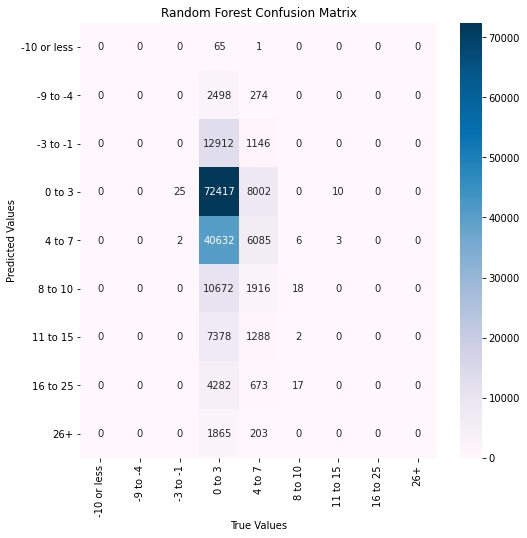

In [0]:
# predictions
y_pred = rf.predict(rf_testX)
# define confusion matrix
cm = confusion_matrix(bin_testY, y_pred)
# plot cm as a heat map
plt.figure(figsize = (8,8))
sns.heatmap(cm, annot = True, cmap = 'PuBu', fmt = 'd') # fmt = 'd' prints integers
plt.title('Random Forest Confusion Matrix')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.xticks(np.arange(0.5,9.5), labels = bin_yard_names, rotation = 90)
plt.yticks(np.arange(0.5,9.5), labels = bin_yard_names, rotation = 0)
plt.show()

In [0]:
print(classification_report(bin_testY, y_pred, target_names = bin_yard_names, zero_division = 0))

              precision    recall  f1-score   support

 -10 or less       0.00      0.00      0.00        66
    -9 to -4       0.00      0.00      0.00      2772
    -3 to -1       0.00      0.00      0.00     14058
      0 to 3       0.47      0.90      0.62     80454
      4 to 7       0.31      0.13      0.18     46728
     8 to 10       0.42      0.00      0.00     12606
    11 to 15       0.00      0.00      0.00      8668
    16 to 25       0.00      0.00      0.00      4972
         26+       0.00      0.00      0.00      2068

    accuracy                           0.46    172392
   macro avg       0.13      0.11      0.09    172392
weighted avg       0.34      0.46      0.34    172392



### Most Important Features

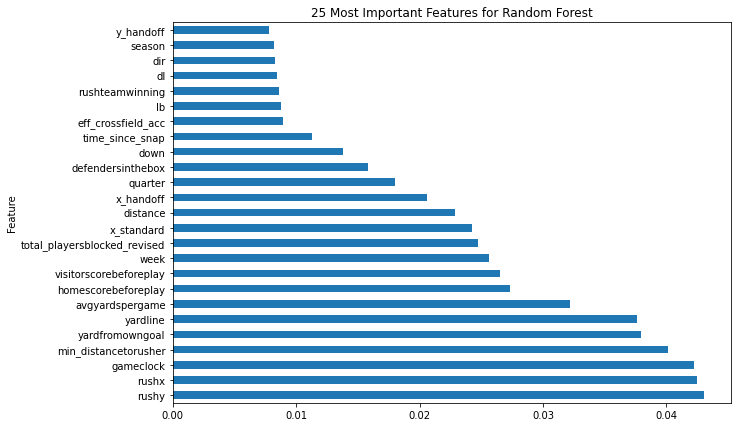

Features
rushy                           0.043039
rushx                           0.042476
gameclock                       0.042213
min_distancetorusher            0.040088
yardfromowngoal                 0.037911
yardline                        0.037638
avgyardspergame                 0.032213
homescorebeforeplay             0.027288
visitorscorebeforeplay          0.026484
week                            0.025615
total_playersblocked_revised    0.024701
x_standard                      0.024230
distance                        0.022904
x_handoff                       0.020598
quarter                         0.018011
defendersinthebox               0.015795
down                            0.013840
time_since_snap                 0.011293
eff_crossfield_acc              0.008961
lb                              0.008760
rushteamwinning                 0.008644
dl                              0.008479
dir                             0.008299
season                          0.008213
y_hando

In [0]:
## Print n most important features
n = 25
plt.figure(figsize = (10, 7))
# impurity-based feature importance
importances = pd.Series(rf.feature_importances_, index = rf_trainX.columns)
# sort values in descending order
importances = importances.sort_values(ascending = False)
# horizontal barplot
importances.nlargest(n).plot(kind = 'barh')
plt.title('25 Most Important Features for Random Forest')
plt.ylabel('Feature')
plt.show()
print('Features')
print(importances[:n])